In [1]:
%matplotlib inline
import bayesian_pdes as bpdes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import GPy, GPyOpt
import scipy, scipy.spatial
import bayesian_design as bd

In [2]:
x_1,x_2, y_1, y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.5
k = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale)**2)
def A(f): return f.diff(x_1,x_1) + f.diff(x_2, x_2)
def Abar(f): return f.diff(y_1,y_1) + f.diff(y_2, y_2)
def Identity(f): return f

ops = [A, Identity]
ops_bar = [Abar, Identity]

obs_per_bdy = 4
# need some observations scattered on the bdy
bdy_locs = [
    [[0., y] for y in np.random.uniform(0,1,obs_per_bdy)],
    [[1., y] for y in np.random.uniform(0,1,obs_per_bdy)],
    [[x, 0.] for x in np.random.uniform(0,1,obs_per_bdy)],
    [[x, 1.] for x in np.random.uniform(0,1,obs_per_bdy)],
]
bdy_locs = np.concatenate(bdy_locs)

bdy_values = np.zeros((bdy_locs.shape[0], 1))
bdy_obs = (bdy_locs, bdy_values)

In [3]:
def vectorize_along_axis(function):
    def __ret(points):
        return np.array([[function(points[i,:])] for i in xrange(points.shape[0])])
    return __ret

In [4]:
op_cache = bpdes.operator_compilation.compile_sympy(ops, ops_bar, k, [[x_1, x_2], [y_1, y_2]], mode='f2py')

In [5]:
# random observation locations inside the space
interior_obs = 10
obs_locations = np.c_[np.random.rand(interior_obs, 1), np.random.rand(interior_obs, 1)]

In [6]:
def rhs(pts):
    return (np.sin(2*np.pi*pts[:,0])*np.sin(2*np.pi*pts[:,1]))[:,None]
obs_values = rhs(obs_locations)

indexer = np.arange(len(obs_locations))
orig_locations = obs_locations.copy()
orig_values = obs_values.copy()
orig_posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(orig_locations, orig_values), bdy_obs], op_cache)

**Deletion function** 

In the terminology of Meyer & Nachtsheim we are using a linear design (i.e. $L(D) = tr(D)$, where D is my variance-covariance matrix). Then following their terminology my deletion function ought to be:

$$
d_L(x_i) = \frac{\phi(x_i)}{1-v(x_i)} \\
\phi(x_i) = L(D f(x_i) f(x_i)^T D) \\
v(x_i) = f(x_i) D f(x_i)^T
$$

Now then the question becomes - who is this $f$ and what does he have to do with anything? It seems that $f$ is like a feature function? i.e. $f^T(x_i)$ is supposed to be the $i$-th row of the design matrix. So am I worrying about nothing? i.e. $\phi = trace(\Sigma)$, $v(x_i) = \Sigma_{ii}$? 

(0, 1)

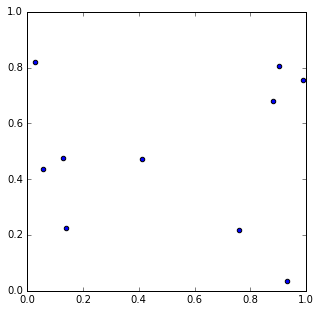

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(orig_locations[:,0], orig_locations[:,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [8]:
def loss_vect(pts):
    return np.array([[loss(pts[i,:])] for i in xrange(pts.shape[0])])

In [9]:
test_x, test_y = np.mgrid[0:1:10j, 0:1:10j]
test_space = np.c_[test_x.ravel(), test_y.ravel()]
adjust_domain = 0.4
emu_length_scale = 0.05
emu_design_points = 20

def design_space(d):
    bounds = get_optimizer_bounds(d)
    xs = np.random.uniform(bounds[0][0], bounds[0][1], emu_design_points)
    ys = np.random.uniform(bounds[1][0], bounds[1][1], emu_design_points)
    return np.c_[xs, ys]

# using just the trace here!
def get_cov(points, at_points=None):
    if at_points is None:
        at_points = test_space
    if points.shape == (2,):
        points = points.reshape((1,2))
    obs = rhs(points)
    posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(points, obs), bdy_obs], op_cache)
    #cov = np.array([posterior(test_space[i,:].reshape((1,2)))[1][0,0] for i in xrange(len(test_space))])
    cov = posterior.diagonal_covariance(at_points)
    #_,cov = posterior(test_space)
    return cov

def get_optimizer_bounds(point):
    return [(max(point[0]-adjust_domain, 0.), min(point[0]+adjust_domain, 1.)), 
            (max(point[1]-adjust_domain, 0.), min(point[1]+adjust_domain, 1.))]

optimizer = bd.optimizers.gpyopt_optimizer(get_optimizer_bounds, True)
loss = bd.a_optimality(get_cov)

In [10]:
def random_design(n_points):
    return np.hstack([np.random.uniform(0,1,interior_obs)[:,None], np.random.uniform(0,1,interior_obs)[:,None]])
def greedy_optimal_design(n_points):
    initial_design = np.empty((n_points,2))
    for i in xrange(n_points):
        cur_points = initial_design[:i,:]
        def partial_loss(p):
            aug_points = np.concatenate((cur_points, p.reshape((1,2))))
            return loss(aug_points)

        opt = GPyOpt.methods.BayesianOptimization(vectorize_along_axis(partial_loss), [(0,1), (0,1)])
        opt.run_optimization()
        initial_design[i,:] = opt.x_opt
    return initial_design

In [ ]:
np.argsort(loss_deltas)[:k]

In [11]:
n_points = 10
initial_design = random_design(n_points)

In [12]:
def pseudo_deletion(points, loss):
    cov = get_cov(points, points)
    return cov.ravel()

0.00146992227431


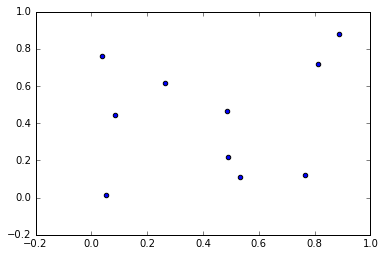

In [13]:
plt.scatter(initial_design[:,0], initial_design[:,1])
print loss(initial_design)
initial_values = rhs(initial_design)
orig_posterior = bpdes.collocate(ops, ops_bar, k, [[x], [y]], [(initial_design, initial_values), bdy_obs], op_cache)

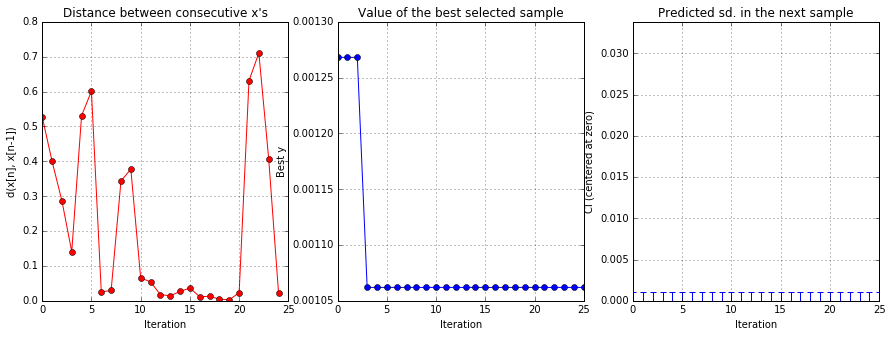

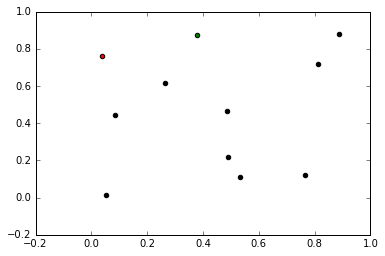

0 Moved 0 from [ 0.03862814  0.76169349] to [ 0.37803615  0.873086  ] (new loss 1.06e-03 < 1.47e-03)


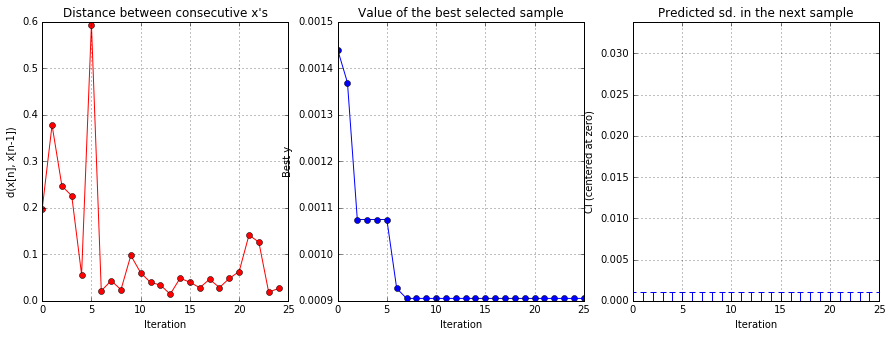

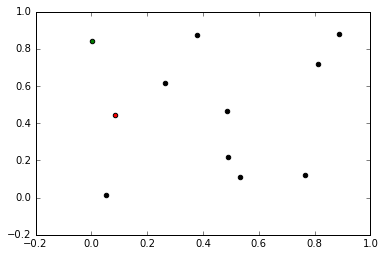

0 Moved 2 from [ 0.08589938  0.44626729] to [ 0.00277398  0.84375959] (new loss 9.05e-04 < 1.06e-03)


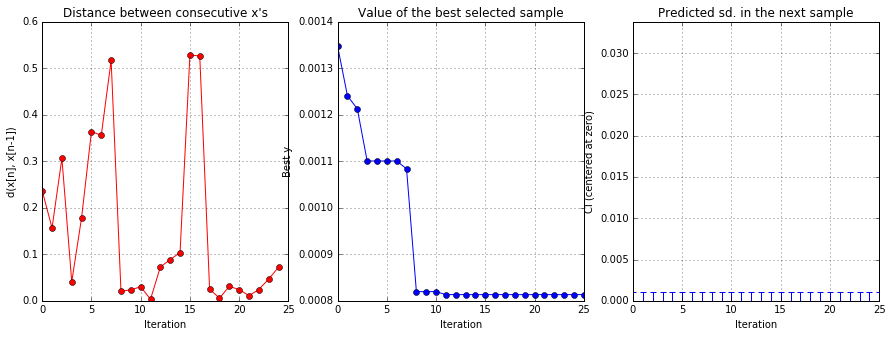

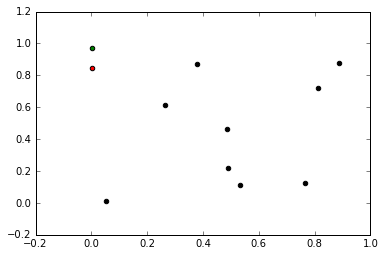

1 Moved 2 from [ 0.00277398  0.84375959] to [  9.15983161e-04   9.72552508e-01] (new loss 8.13e-04 < 9.05e-04)


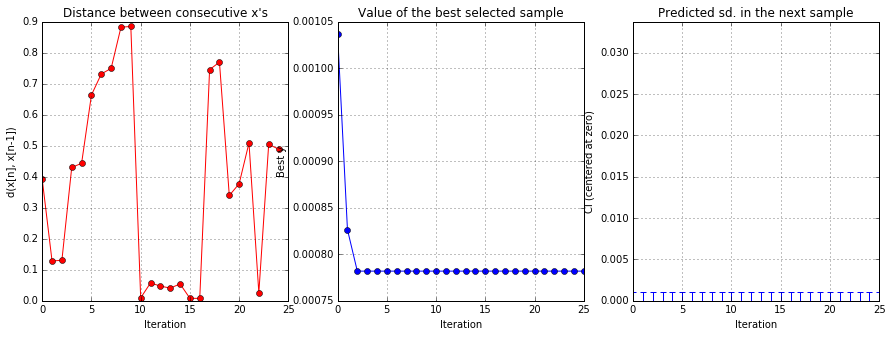

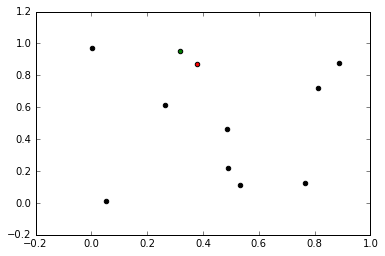

1 Moved 0 from [ 0.37803615  0.873086  ] to [ 0.31780355  0.95290901] (new loss 7.82e-04 < 8.13e-04)


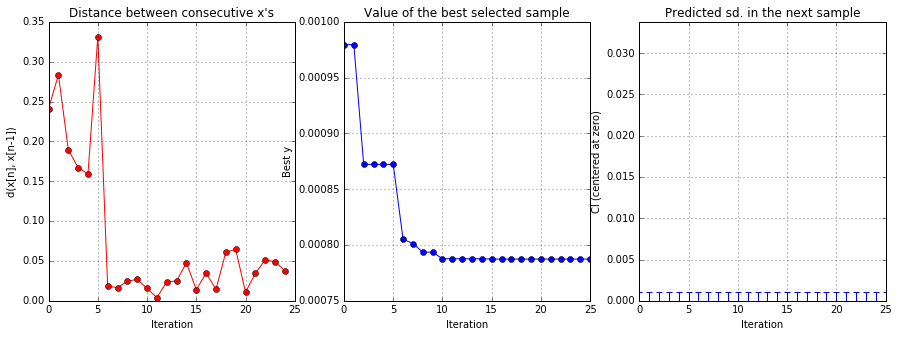

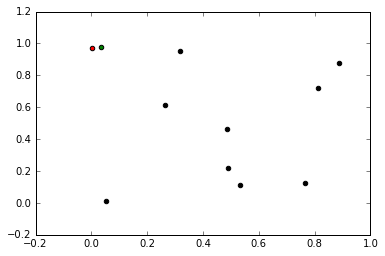

2 Rejected move of 2 from [  9.15983161e-04   9.72552508e-01] to [ 0.03441368  0.97809627], (new loss 7.87e-04 > 7.82e-04)


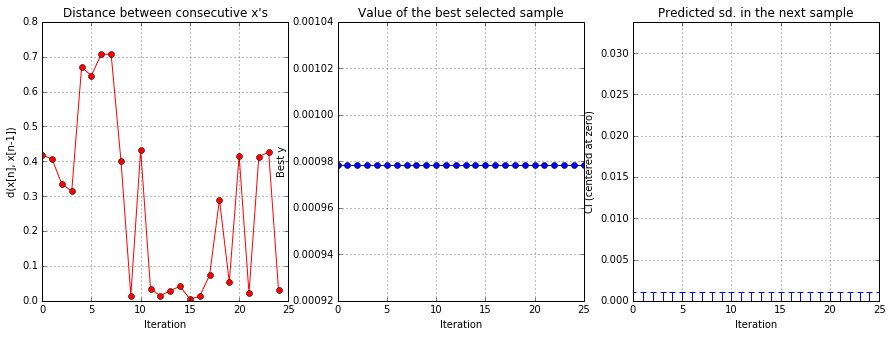

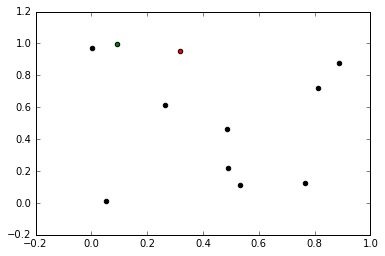

2 Rejected move of 0 from [ 0.31780355  0.95290901] to [ 0.09073776  0.99384615], (new loss 9.78e-04 > 7.82e-04)


In [14]:
optimal_design = bd.ace( 
    initial_design, 
    2, 
    10, 
    loss, 
    optimizer, 
    deletion_function=pseudo_deletion,
    terminate_rejects=1,
    debug=True
)

In [17]:
initial_posterior = bpdes.collocate(ops, ops_bar, k, None, [(initial_design, rhs(initial_design)), bdy_obs], op_cache)
optimal_posterior = bpdes.collocate(ops, ops_bar, k, None, [(optimal_design, rhs(optimal_design)), bdy_obs], op_cache)

plot_x, plot_y = np.mgrid[0:1:40j, 0:1:40j]
mu_init, cov_init = initial_posterior(np.c_[plot_x.ravel(), plot_y.ravel()])
mu_opt, cov_opt = optimal_posterior(np.c_[plot_x.ravel(), plot_y.ravel()])

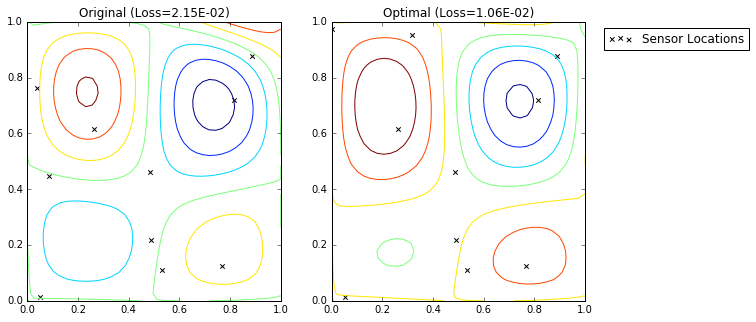

In [16]:
from IPython.display import display
plt.figure(figsize=(10,5))

plt.subplot(121)
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
plt.contour(plot_x, plot_y, mu_init.reshape(plot_x.shape))
plt.scatter(initial_design[:,0], initial_design[:,1], c='black', marker='x')
plt.title('Original (Loss={:.2E})'.format(np.trace(cov_init)))
plt.xlim(0,1); plt.ylim(0,1);

plt.subplot(122)
#plt.plot(test_points, np.random.multivariate_normal(mu.ravel(),cov,500).T, c='gray', alpha=0.1)
plt.contour(plot_x, plot_y, mu_opt.reshape(plot_x.shape))
plt.scatter(optimal_design[:,0], optimal_design[:,1], c='black', marker='x', label='Sensor Locations')
plt.title('Optimal (Loss={:.2E})'.format(np.trace(cov_opt)))
lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1))
plt.xlim(0,1); plt.ylim(0,1);
plt.savefig('bayesian_design.pdf', bbox_extra_artists=(lgd,), transparent=True, bbox_inches='tight')